# Analisi Multivariata di due classi di eventi

Si generino in primis due classi di eventi distribuiti secondo una Breit-Wigner

$$
f_{H0}(x,y) = \frac{1}{4\pi^2} \frac{1}{\left(\frac{1}{4} + (x-0)^2\right)\left(\frac{1}{4} + (y-1)^2\right)}
$$

E, quindi, una gaussiana multivariata con matrice di covarianza non diagonale:

$$f_{H1}(x,y) =
      \frac{1}{2 \pi  \sigma_X \sigma_Y \sqrt{1-\rho^2}}
      \exp\left(
        -\frac{1}{2(1-\rho^2)}\left[
          \frac{(x-\mu_X)^2}{\sigma_X^2} +
          \frac{(y-\mu_Y)^2}{\sigma_Y^2} -
          \frac{2\rho(x-\mu_X)(y-\mu_Y)}{\sigma_X \sigma_Y}
        \right]
      \right)$$

Con:
$$
\begin{cases}
&\sigma_x=\sigma_y=1\\
&\rho = 0.4\\
&\mu_x = \mu_y = 4
\end{cases}
$$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.optimize as op

mean_x_BW = 0.        # x_0
mean_y_BW = 1.        # y_0
FWHM = 1.             # Gamma = 1

mean_x_G = 4          # mu_x = 4
mean_y_G = 4          # mu_y = 4
sigma = 1.
rho = 0.4

NSignal =  5e3        # Numero di eventi di ciascuna classe generati
np.random.seed()      # Imposto il seed
signal = []           # Creo una lista da riempire con gli eventi

### Definisco le pdf
def Breit_Wigner (x, y, mean_x, mean_y, FWHM):
        return ((1./math.pi) * (FWHM/2.) / (FWHM**2/4. + (x - mean_x)**2)) * ((1./math.pi) * (FWHM/2.) / (FWHM**2/4. + (y - mean_y)**2))

def Multivariate_Gaussian (x,y, mean_x, mean_y, sigma, rho):
        r = 1 - rho**2
        sigma2 = sigma**2
        return (2*math.pi * sigma2 * math.sqrt(r))**(-1) * math.exp( -1. / (2. * sigma2 * r) * ( (x - mean_x)**2 + (y - mean_y)**2 - (2*rho * (x - mean_x) * (y - mean_y))  ) )

Genero gli eventi della prima classe utilizzando il metodo *Hit and Miss* ripetuto fino a che il numero di eventi non è pari alla variabile *NSignal*.

Setto la x e la y massime degli eventi a +10 e -10 volte la *Full Width Half Maximum*.

Salvo il segnale nella lista apposita come una lista formata da 1 array contenente le coordinate dell'evento e un numero indicante l'appartenenza alla prima (0) o seconda classe (1).

In [4]:
print("Generazione segnale (BW)...")
signal_BW = []  #creo la lista dove immagazzino il segnale

result = np.array([mean_x_BW,  mean_y_BW], float)
while len(signal_BW) < NSignal: #Uso il metodo Hit n Miss
        result = [0,0]                                  # Assegno alla terza componente il valore 1 agli elementi di BW e quello 0 a quelli di Gaussiana
        result[0], result[1] = np.random.uniform(mean_x_BW - 10*FWHM, mean_x_BW + 10*FWHM), np.random.uniform(mean_y_BW - 10*FWHM, mean_y_BW + 10*FWHM)
        #due numeri casuali tra -10 e 10 e -10 e 10
        probabilita = np.random.uniform(0.,1.)
        if probabilita < Breit_Wigner(result[0], result[1], mean_x_BW, mean_y_BW, FWHM):
                signal_BW.append([result, 0])
                signal.append([result, 0])

Generazione segnale (BW)...


Genero successivamente, gli eventi della seconda classe utilizzando il metodo della decomposizione di Cholesky.
Prendendo la matrice triangolare $L$ inferiore della decomposizione di Cholesky della matrice di Covarianza e applicandola ad un vettore di variabili gaussiane scorrelate $\vec{X}$ il risultato è un vettore $\vec{Y}$ di variabili gaussiane correlate:

$$\vec{Y} = L \vec{X}$$

Genero quindi l'array $result$ usando il generatore di NumPy random.normal( ) e lo moltiplico per la matrice $L$ salvando poi i risultati nella solita lista.

In [38]:
print("Generazione segnale (Gauss)...")
signal_Gauss = []
L = np.array([[1, 0],[rho, math.sqrt(1 - rho**2)]], float)
#[[1.         0.        ]
#[0.4        0.91651514]]


while len(signal_Gauss) < NSignal:
        result = [0,0]

        result[0], result[1] = np.random.normal(mean_x_G, sigma), np.random.normal(mean_y_G, sigma)
        result = np.dot(L,result)     # Moltiplico il vettore per la matrice.
        signal_Gauss.append([result, 1])
        signal.append([result, 1])    # Salvo il risultato come le coordinate e l'intero 1


Generazione segnale (Gauss)...


Per dividere i due eventi, essendo note le pdf, e quindi le funzioni di verosimiglianza, utilizzo il lemma di Neyman-Pearson, il quale asserisce che, quando si opera un test di verifica d'ipotesi tra due ipotesi semplici $H_0$: $\theta$ = $\theta_0$ e $H_1$:$\theta$= $\theta_1$, il rapporto delle funzioni di verosimiglianza che rigetta $H_0$ in favore di $H_1$ quando:
$$\Lambda(x):=\frac{ L( \theta _{0} \mid x)}{ L (\theta _{1} \mid x)} \leq c\qquad \mbox{ con } P(\Lambda(X)\leq k|H_0)=\alpha$$


rappresenta il test di verifica più potente a livello di significatività $\alpha$ per una soglia c.

In [40]:
print("Classificazione...")
classification_result = np.zeros(len(signal))       # Lista dei risultati della classificazione
c = 1.                                              # Setto la soglia, l'evento viene assegnato
                                                    # alla classe con verosimiglianza maggiore
    
x = [x[0] for x in [x[0] for x in signal]]          # Creo una lista con le coordinate x e una con y
y = [y[1] for y in [y[0] for y in signal]]
true_class = [x[1] for x in signal] #0 o 1          # Creo una lista con l'etichetta di ciascun evento

signal_BW_classified = []                           # Liste in cui immagazzino gli eventi classificati
signal_Gauss_classified = []

Type1 = 0                                           # Inizializzo a 0 gli errori di primo e secondo tipo
Type2 = 0

for i in range(len(signal)):
        # Calcolo il t-value
        t = Breit_Wigner (x[i], y[i], mean_x_BW, mean_y_BW, FWHM) / Multivariate_Gaussian (x[i],y[i], mean_x_G, mean_y_G, sigma, rho)

        if (t > c):
                classification_result[i] = 0
                signal_BW_classified.append([x[i],y[i]])
                if true_class[i] != 0:       # Se la classe assegnata non coincide con la vera incremento l'errore
                        Type2 += 1

        else:
                classification_result[i] = 1
                signal_Gauss_classified.append([x[i],y[i]])
                if true_class[i] != 1:       # Se la classe assegnata non coincide con la vera incremento l'errore
                        Type1 += 1 

            

Classificazione...


Infine stampo a schermo il numero di eventi classificati come Breit-Wigner ($H_0$), quello di eventi gaussiani $H_1$ e il numero di errori del primo e secondo tipo. 

Uso questi dati per calcolare l'efficienza del test:

$\varepsilon_{H0} = 1 - \alpha$

dove con $\alpha$ si indica la probabilità di errori del primo tipo,
e la purezza del segnale, indicata come la probabilità che un evento sotto la soglia di rigetto di ipotesi nulla sia effettivamente di segnale:

$\pi = 1 - \beta$

dove con $\beta$ si indica la probabilità di errori del secondo tipo.


--- Risultati ---
Eventi Breit-Wigner (H0):  4972
Eventi Gaussiani (H1):  5028
Errori Tipo 1 (Falso Positivo):  81
Errori Tipo 2 (Falso Negativo):  53
Efficienza del test (1 - alfa):  98.4 %
Purezza del segnale (1 - beta):  98.9 %


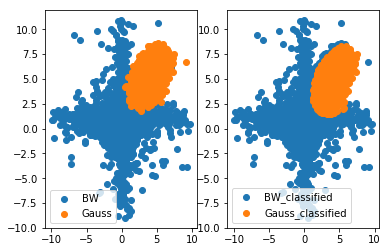

In [5]:
# Stampo i risultati a schermo            
print("\n--- Risultati ---")
print("Eventi Breit-Wigner (H0): ", len(signal_BW_classified))
print("Eventi Gaussiani (H1): ", len(signal_Gauss_classified))
print("Errori Tipo 1 (Falso Positivo): ", Type1)
print("Errori Tipo 2 (Falso Negativo): ", Type2)

###     efficienza è la probabilità di non avere un falso positivo, ossia di non dichiarare fondo un evento di segnale
efficienza = 1 - Type1/len(signal_BW_classified)
print("Efficienza del test (1 - alfa): ", round(efficienza*1000.)/10., "%")

###     La purezza del segnale è il numero di eventi di segnale accettati diviso il numero di eventi accettati
purezza = 1 - (Type2 / len(signal_BW_classified))
print("Purezza del segnale (1 - beta): ", round(purezza*1000.)/10., "%")        




# Plot dei dati
plt.subplot(121)
plt.scatter([x[0] for x in [x[0] for x in signal_BW]], [y[1] for y in [y[0] for y in signal_BW]], label="BW")   #Nota che l'ultimo y e' y[0] perche' devi prendere il primo elemento che
plt.scatter([x[0] for x in [x[0] for x in signal_Gauss]], [y[1] for y in [y[0] for y in signal_Gauss]], label="Gauss")  #e' il vettore, e non l'indice!
plt.legend()

plt.subplot(122)

plt.scatter([x[0] for x in signal_BW_classified],[ y[1] for y in signal_BW_classified], label="BW_classified")
plt.scatter([x[0] for x in signal_Gauss_classified], [y[1] for y in signal_Gauss_classified], label="Gauss_classified")
plt.legend()
plt.show()
